In [14]:
import pandas as pd
from ast import literal_eval
from bs4 import BeautifulSoup
from tqdm import tqdm
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import time
import pyLDAvis
import pyLDAvis.gensim_models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
import sklearn.metrics as metrics
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from transformers import TFAutoModel,AutoTokenizer
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow_hub as hub
import joblib

## Importation des données

In [15]:
data = pd.read_csv("C:/Users/ctripie/Documents/OPC/Projet 5/TextClean.csv")
data.head(10)

,Id,Body_cleaned,Title_cleaned,Tags_list,Full_text
0,19981949,working formerly twitter bootstrap style butto...,make button bootstrap look like normal link,"['html', 'css']",make button bootstrap look like normal link wo...
1,557159,normal loop break loop break done anonymous de...,exit loop anonymous delegate,['c#'],exit loop anonymous delegate normal loop break...
2,557582,doc use instead context pointer,null v nil,['objective-c'],null v nil doc use instead context pointer
3,19982053,many web page new git integration v deal solut...,add solution visual studio,['git'],add solution visual studio many web page new g...
4,557844,wondering technique library use implement func...,io implementation tail f,['java'],io implementation tail f wondering technique l...
5,557959,string equal date number millisecond since epo...,convert millisecond date,"['php', 'datetime']",convert millisecond date string equal date num...
6,558122,question plain c function c method comment und...,static function c,['c'],static function c question plain c function c ...
7,19982257,scattered around still clear difference usage ...,render v outlet v partial v view v control,['javascript'],render v outlet v partial v view v control sca...
8,556771,get example used necessary want disabled whole...,c warning restore,['c#'],c warning restore get example used necessary w...
9,556775,difference attribute property instead member v...,attribute property v member,['.net'],attribute property v member difference attribu...


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43910 entries, 0 to 43909
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             43910 non-null  int64 
 1   Body_cleaned   43894 non-null  object
 2   Title_cleaned  43334 non-null  object
 3   Tags_list      43910 non-null  object
 4   Full_text      43910 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [17]:
data["Tags_list"]=data["Tags_list"].apply(literal_eval)

In [18]:
# Define X and y
X = data["Full_text"]
y = data["Tags_list"]

# Initialize the "CountVectorizer" TFIDF for Full_doc
vectorizer = TfidfVectorizer(stop_words='english')

vectorizer.fit(X)
X_tfidf = vectorizer.transform(X)

print("Shape of X for Full_doc: {}".format(X_tfidf.shape))

# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)

print("Shape of y: {}".format(y_binarized.shape))

Shape of X for Full_doc: (43910, 10651)
Shape of y: (43910, 50)


# Modèle non-supervisés

### LDA

In [19]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(data['Full_text'])

print (data_words[0])

['make', 'button', 'bootstrap', 'look', 'like', 'normal', 'link', 'working', 'formerly', 'twitter', 'bootstrap', 'style', 'button', 'though', 'normal', 'link', 'normal', 'link', 'though', 'going', 'container', 'markup', 'end', 'like', 'bootstrap', 'way', 'make', 'look', 'like', 'actually']


In [20]:
# Create dictionnary (bag of words)
id2word = corpora.Dictionary(data_words)
# Create Corpus 
texts = data_words  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 1), (1, 3), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 3), (8, 3), (9, 2), (10, 2), (11, 1), (12, 3), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1)]]


In [21]:
# Iter LDA for best number of topics
coherence_test = []
for k in np.arange(1,21,1):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=k)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1
Fitting LDA for K = 2
Fitting LDA for K = 3
Fitting LDA for K = 4
Fitting LDA for K = 5
Fitting LDA for K = 6
Fitting LDA for K = 7
Fitting LDA for K = 8
Fitting LDA for K = 9
Fitting LDA for K = 10
Fitting LDA for K = 11
Fitting LDA for K = 12
Fitting LDA for K = 13
Fitting LDA for K = 14
Fitting LDA for K = 15
Fitting LDA for K = 16
Fitting LDA for K = 17
Fitting LDA for K = 18
Fitting LDA for K = 19
Fitting LDA for K = 20


In [22]:
# Create dataframe of results
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])
coherence_test

,k,coherence,time
0,1,0.378117,10.898182
1,2,0.396251,20.360241
2,3,0.408619,22.282023
3,4,0.405128,22.717324
4,5,0.409431,22.905706
5,6,0.421355,24.140986
6,7,0.423055,24.890111
7,8,0.427881,25.609036
8,9,0.427365,28.080020
9,10,0.431858,27.656219


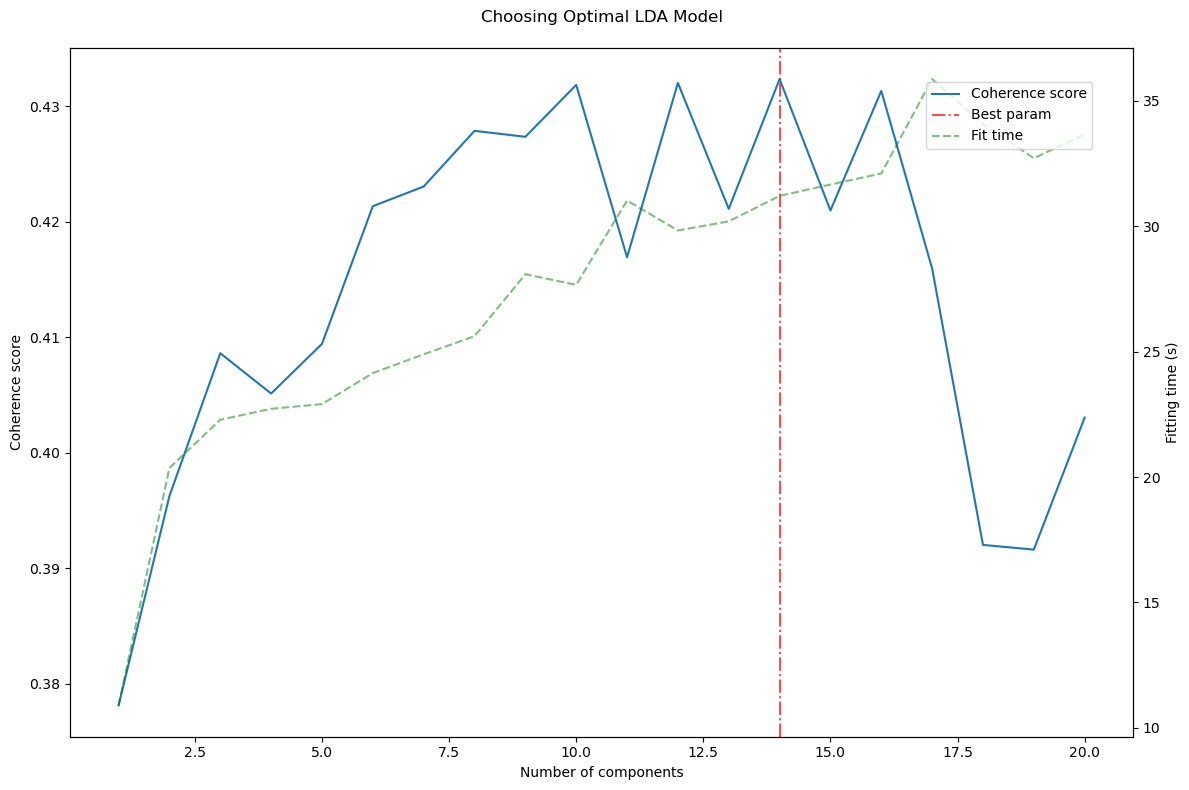

In [23]:
# Select best number of topics
best_nb_topics = coherence_test.loc[coherence_test.coherence.argmax(),"k"]

# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_nb_topics, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

plt.title("Choosing Optimal LDA Model\n")
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()

In [24]:
# Construire le modèle LDA optimal
best_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=best_nb_topics)

In [25]:
# Best LDA visualization
vis = pyLDAvis.gensim_models.prepare(best_lda_model, corpus, id2word)

pyLDAvis.display(vis)

**LDA** = topics dure à interpreter, se superposent (tres proches les uns des autres), pas de methode de prediction, calcul des tags fastidieux.

### NMF

In [26]:
def plot_top_words(model, feature_names, 
                   n_top_words, nb_topic_plot, title):
    """Function for displaying the plots of the 
    best x words representative of the categories of NMF.

    Parameters
    ----------------------------------------
    model : NMF model
        Fitted model of NMF to plot
    feature_names : array
        Categories result of the vectorizer (TFIDF ...)
    n_top_words : int
        Number of words for each topic.
    title : string
        Title of the plot.
    ----------------------------------------
    """
    rows = int(nb_topic_plot/5)
    fig, axes = plt.subplots(rows, 5, 
                             figsize=(30, rows*10), 
                             sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        if(topic_idx < nb_topic_plot):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            bartopic = ax.barh(top_features, weights, height=0.7)
            bartopic[0].set_color('#f48023')
            ax.set_title(f'Topic {topic_idx +1}',
                         fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=36, color="#641E16")

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

--------------------------------------------------
Start NMF fitting on Full_doc ...
--------------------------------------------------
End of training :
Execution time : 3.26s
--------------------------------------------------


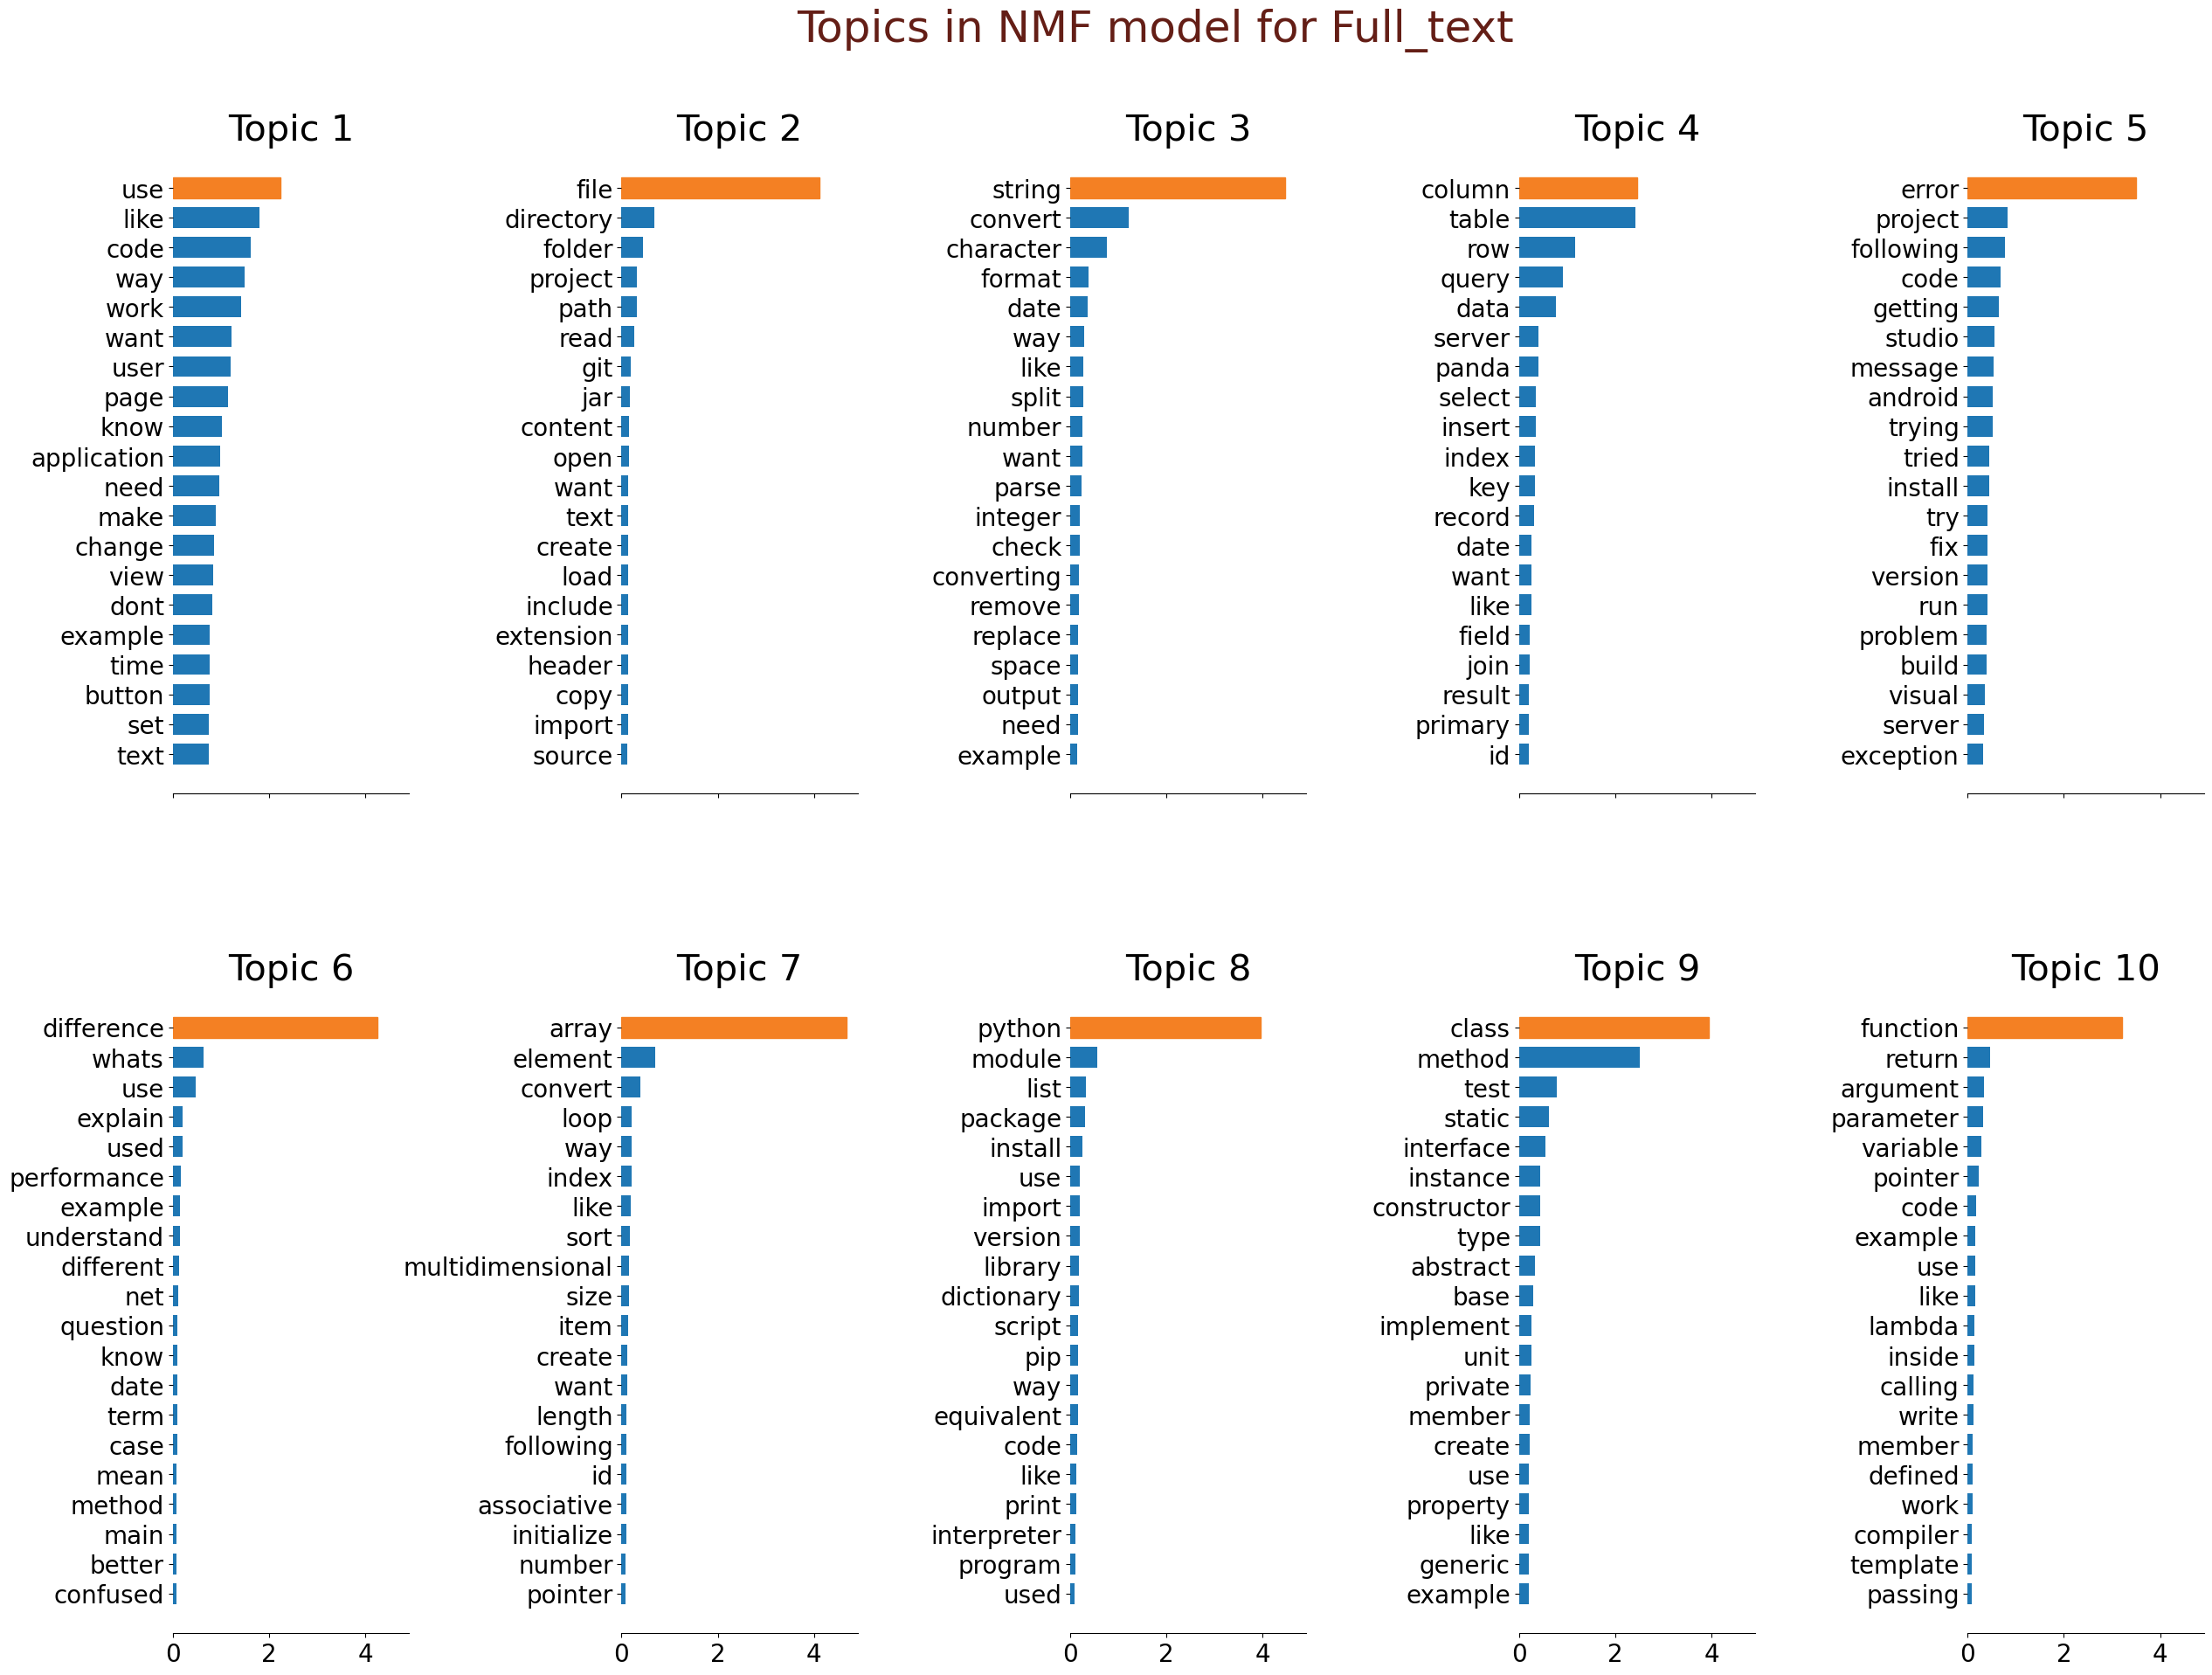

In [27]:
# Define number of topics to test
n_topics = best_nb_topics

print("-"*50)
print("Start NMF fitting on Full_doc ...")
print("-" * 50)
start_time = time.time()
# Initializing the NMF
full_nmf = NMF(n_components=n_topics,
               init='nndsvd',
               random_state=8)

# Fit NMF on Body vectorized
full_nmf.fit(X_tfidf)

exec_time = time.time() - start_time
print("End of training :")
print("Execution time : {:.2f}s".format(exec_time))
print("-" * 50)

# Plot the 10 first topics
ff_feature_names = vectorizer.get_feature_names_out()
plot_top_words(full_nmf, ff_feature_names, 20, 10,
               'Topics in NMF model for Full_text')

**NMF** = comme pour le LDA, topic génraux et categorisation peu cohérente; pas scorable

# Modèles supervisés

Echantillonnage des données pour avoir des temps de traitements raccourcis

In [16]:
sample = data.sample(n=20000, random_state=42)
sample.shape

(20000, 5)

In [17]:
# Define X and y
X = sample["Full_text"]
y = sample["Tags_list"]

# Initialize the "CountVectorizer" TFIDF for Full_doc
vectorizer = TfidfVectorizer(stop_words='english')

vectorizer.fit(X)
X_tfidf = vectorizer.transform(X)

print("Shape of X for Full_doc: {}".format(X_tfidf.shape))

# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)

print("Shape of y: {}".format(y_binarized.shape))

Shape of X for Full_doc: (20000, 8415)
Shape of y: (20000, 50)


In [18]:
def models_train(model, df):
    """
    Parameters
    ----------------------------------------
    model : string
        Name of the tested model
    df : DataFrame 
        DataFrame to extend. 
        If None : Create DataFrame.
    ----------------------------------------
    """
    if(df is not None):
        temp_df = df
    else:
        temp_df = pd.DataFrame(index=["Accuracy",
                                      "Jaccard",
                                      "Hamming",
                                      "Train Time",
                                      "Test Time"],
                               columns=[model])
        
    start = time.time()
    model.fit(X_train,y_train)
    end = time.time()
    train_time = end-start

    start2 = time.time()
    y_pred = model.predict(X_test)
    end2 = time.time()
    test_time = end2-start2
        
    scores = []
    scores.append(metrics.accuracy_score(y_test, 
                                         y_pred))
    scores.append(metrics.jaccard_score(y_test, 
                                   y_pred, 
                                   average='weighted'))
    scores.append(metrics.hamming_loss(y_test, 
                                        y_pred))
    scores.append(train_time)
    scores.append(test_time)
    
    temp_df[model] = scores
    
    return temp_df

# Extraction features : Bag of words

In [19]:
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized,
                                                    test_size=0.3, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (14000, 8415)
X_test shape : (6000, 8415)
y_train shape : (14000, 50)
y_test shape : (6000, 50)


### Logistic Regression

In [21]:
LR_bow = OneVsRestClassifier(LogisticRegression())

In [22]:
df_metrics_bow = models_train(LR_bow,None)

In [23]:
df_metrics_bow

,OneVsRestClassifier(estimator=LogisticRegression())
Accuracy,0.151333
Jaccard,0.204311
Hamming,0.025497
Train Time,4.951093
Test Time,0.000000


### SVC

In [24]:
SVC_bow = OneVsRestClassifier(SVC())

In [25]:
df_metrics_bow = models_train(SVC_bow,df_metrics_bow)

In [26]:
df_metrics_bow

,OneVsRestClassifier(estimator=LogisticRegression()),OneVsRestClassifier(estimator=SVC())
Accuracy,0.151333,0.170167
Jaccard,0.204311,0.220868
Hamming,0.025497,0.024713
Train Time,4.951093,401.609247
Test Time,0.000000,132.925316


### Random Forest

In [27]:
RF_bow = OneVsRestClassifier(RandomForestClassifier())

In [28]:
df_metrics_bow = models_train(RF_bow,df_metrics_bow)

In [29]:
df_metrics_bow

,OneVsRestClassifier(estimator=LogisticRegression()),OneVsRestClassifier(estimator=SVC()),OneVsRestClassifier(estimator=RandomForestClassifier())
Accuracy,0.151333,0.170167,0.142833
Jaccard,0.204311,0.220868,0.159535
Hamming,0.025497,0.024713,0.026257
Train Time,4.951093,401.609247,1030.850195
Test Time,0.000000,132.925316,8.657149


# Extraction features : Word2vec

In [30]:
sample['Full_text'].apply(lambda x: len(x)).median()

179.0

In [31]:
w2v_size=200
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 178 # adapt to length of sentences
sentences = sample['Full_text'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [32]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 8603
Word2Vec trained


In [33]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 8604


In [34]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 200
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0

for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (8604, 200)


In [35]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input],word_vec)

embed_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 178)]             0         
                                                                 
 embedding (Embedding)       (None, 178, 200)          1720800   
                                                                 
 global_average_pooling1d (  (None, 200)               0         
 GlobalAveragePooling1D)                                         
                                                                 
Total params: 1720800 (6.56 MB)
Trainable params: 1720800 (6.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

625/625 [==============================] - 1s 1ms/step


(20000, 200)

In [37]:
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(embeddings, y_binarized,
                                                    test_size=0.3, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (14000, 200)
X_test shape : (6000, 200)
y_train shape : (14000, 50)
y_test shape : (6000, 50)


### Logistic Regression

In [38]:
LR_w2v = OneVsRestClassifier(LogisticRegression())

In [39]:
df_metrics_w2v = models_train(LR_w2v,None)

In [40]:
df_metrics_w2v

,OneVsRestClassifier(estimator=LogisticRegression())
Accuracy,0.114000
Jaccard,0.159572
Hamming,0.027670
Train Time,7.423680
Test Time,0.203565


### SVC

In [41]:
SVC_w2v = OneVsRestClassifier(SVC())

In [42]:
df_metrics_w2v = models_train(SVC_w2v,df_metrics_w2v)

In [43]:
df_metrics_w2v

,OneVsRestClassifier(estimator=LogisticRegression()),OneVsRestClassifier(estimator=SVC())
Accuracy,0.114000,0.125833
Jaccard,0.159572,0.154013
Hamming,0.027670,0.026383
Train Time,7.423680,154.437703
Test Time,0.203565,67.690325


### Random Forest

In [44]:
RF_w2v = OneVsRestClassifier(RandomForestClassifier())

In [45]:
df_metrics_w2v = models_train(RF_w2v,df_metrics_w2v)

In [46]:
df_metrics_w2v

,OneVsRestClassifier(estimator=LogisticRegression()),OneVsRestClassifier(estimator=SVC()),OneVsRestClassifier(estimator=RandomForestClassifier())
Accuracy,0.114000,0.125833,0.035333
Jaccard,0.159572,0.154013,0.043026
Hamming,0.027670,0.026383,0.029440
Train Time,7.423680,154.437703,1595.288168
Test Time,0.203565,67.690325,3.579367


# Extraction features : BERT

In [47]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                      bert_tokenizer, max_length)

        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids,
                                 "input_mask" : attention_mask,
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

In [48]:
max_length = 178
batch_size = 200 #nombre de phrases
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = sample['Full_text'].to_list()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [49]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 45s 45s/step
temps traitement :  7167.0


In [50]:
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(features_bert, y_binarized,
                                                    test_size=0.3, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (14000, 768)
X_test shape : (6000, 768)
y_train shape : (14000, 50)
y_test shape : (6000, 50)


### Logistic Regression

In [51]:
LR_bert = OneVsRestClassifier(LogisticRegression())

In [52]:
df_metrics_bert = models_train(LR_bert,None)

In [53]:
df_metrics_bert

,OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))
Accuracy,0.138833
Jaccard,0.195033
Hamming,0.027023
Train Time,150.000444
Test Time,0.734935


### SVC

In [54]:
SVC_bert = OneVsRestClassifier(SVC())

In [55]:
df_metrics_bert = models_train(SVC_bert,df_metrics_bert)

In [56]:
df_metrics_bert

,OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000)),OneVsRestClassifier(estimator=SVC())
Accuracy,0.138833,0.066833
Jaccard,0.195033,0.070558
Hamming,0.027023,0.028460
Train Time,150.000444,380.873276
Test Time,0.734935,173.247371


### Random Forest

In [57]:
RF_bert = OneVsRestClassifier(RandomForestClassifier())

In [58]:
df_metrics_bert = models_train(RF_bert,df_metrics_bert)

In [59]:
df_metrics_bert

,OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000)),OneVsRestClassifier(estimator=SVC()),OneVsRestClassifier(estimator=RandomForestClassifier())
Accuracy,0.138833,0.066833,0.016000
Jaccard,0.195033,0.070558,0.015937
Hamming,0.027023,0.028460,0.030153
Train Time,150.000444,380.873276,6909.685245
Test Time,0.734935,173.247371,8.017009


# Extraction features : USE

In [60]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)

In [61]:
def embed(input):
    return model(input)

In [62]:
sentences = sample['Full_text'].to_list()

In [63]:
features_USE = embed(sentences)

In [64]:
features_USE = np.array(features_USE)

In [65]:
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(features_USE, y_binarized,
                                                    test_size=0.3, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (14000, 512)
X_test shape : (6000, 512)
y_train shape : (14000, 50)
y_test shape : (6000, 50)


### Logistic Regression

In [66]:
LR_use = OneVsRestClassifier(LogisticRegression())

In [67]:
df_metrics_use = models_train(LR_use,None)

In [68]:
df_metrics_use

,OneVsRestClassifier(estimator=LogisticRegression())
Accuracy,0.221333
Jaccard,0.280353
Hamming,0.023800
Train Time,15.139716
Test Time,0.547435


### SVC

In [69]:
SVC_use = OneVsRestClassifier(SVC())

In [70]:
df_metrics_use = models_train(SVC_use,df_metrics_use)

In [71]:
df_metrics_use

,OneVsRestClassifier(estimator=LogisticRegression()),OneVsRestClassifier(estimator=SVC())
Accuracy,0.221333,0.226000
Jaccard,0.280353,0.275954
Hamming,0.023800,0.023333
Train Time,15.139716,242.518477
Test Time,0.547435,108.690857


### Random Forest

In [72]:
RF_use = OneVsRestClassifier(RandomForestClassifier())

In [73]:
df_metrics_use = models_train(RF_use,df_metrics_use)

In [74]:
df_metrics_use

,OneVsRestClassifier(estimator=LogisticRegression()),OneVsRestClassifier(estimator=SVC()),OneVsRestClassifier(estimator=RandomForestClassifier())
Accuracy,0.221333,0.226000,0.115000
Jaccard,0.280353,0.275954,0.139695
Hamming,0.023800,0.023333,0.026710
Train Time,15.139716,242.518477,4432.381341
Test Time,0.547435,108.690857,5.767315


# Comparaison des scores

In [75]:
dataframes = [df_metrics_bow, df_metrics_w2v, df_metrics_bert, df_metrics_use]

In [76]:
names = ['BoW','W2V','BERT','USE']

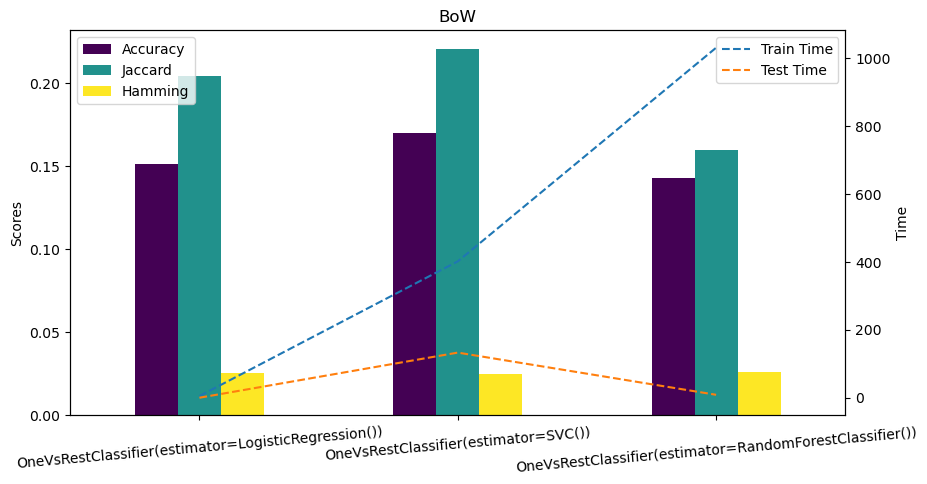

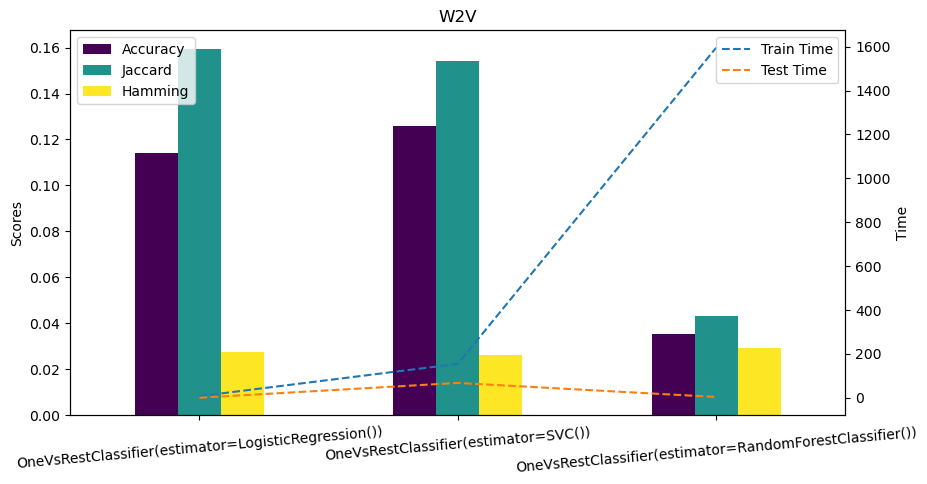

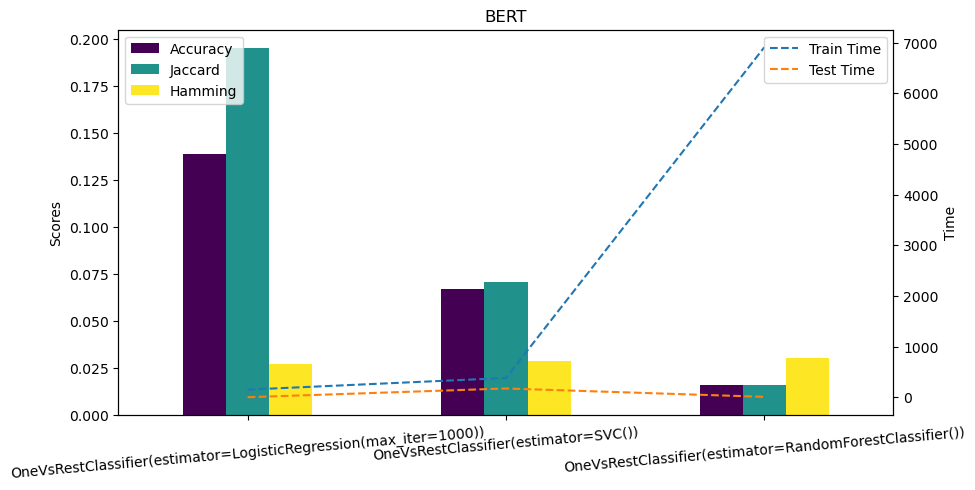

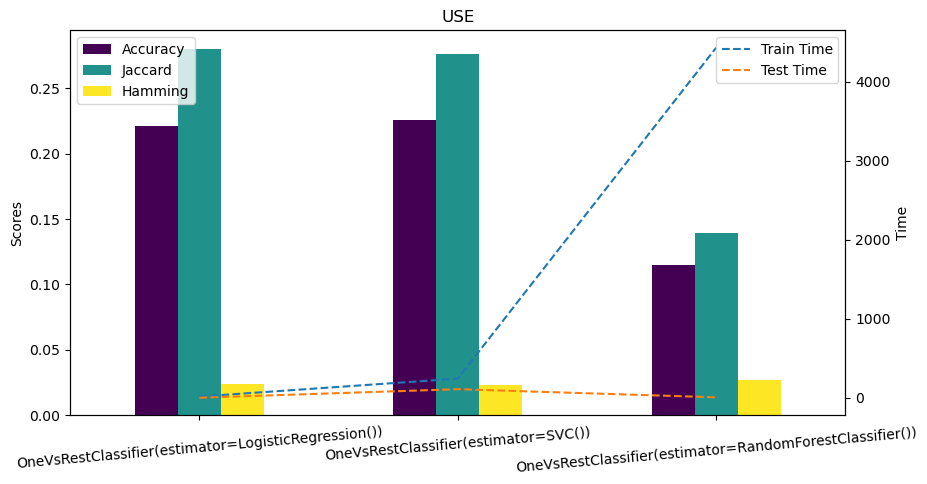

In [77]:
for df,name in zip(dataframes,names) : 
    df_t = df.transpose()
    
    fig, ax1 = plt.subplots(figsize=(10,5))
    ax2 = ax1.twinx()
    df_t.iloc[:,0:3].plot(kind='bar',ax=ax1,colormap='viridis')
    df_t.iloc[:,3:5].plot(kind='line',ax=ax2,linestyle='--')
    ax1.set_ylabel('Scores')
    ax1.legend(loc=2)
    ax1.tick_params(axis='x', labelrotation=5)
    ax2.set_ylabel('Time')
    plt.title(name)

In [78]:
df_metrics_use

,OneVsRestClassifier(estimator=LogisticRegression()),OneVsRestClassifier(estimator=SVC()),OneVsRestClassifier(estimator=RandomForestClassifier())
Accuracy,0.221333,0.226000,0.115000
Jaccard,0.280353,0.275954,0.139695
Hamming,0.023800,0.023333,0.026710
Train Time,15.139716,242.518477,4432.381341
Test Time,0.547435,108.690857,5.767315


**Les meilleurs scores sont obtenus sur le modèle de régression logistique, grâce à la méthode Universal Sentence Encoder.** 

Sauvegarde des modèles pour l'utilisation dans l'API 

In [80]:
joblib.dump(LR_use,'model_lr')
joblib.dump(multilabel_binarizer,'multilabel_binarizer')

['multilabel_binarizer']